In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import math
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [30]:
#read apple stocks from the csv file
df = pd.read_csv('SPY.csv')
sample['date'] = pd.to_datetime(sample['date'], format = 'Y%-%m-%d %H:%M:%S')
#get row of date and close
sample = df[['date','close']][:550].set_index('date')
#initiate window size to 2
window_size = 2
num_features = 1
###training preprocessing###
#get first 500 numbers of sample row
train = sample[:500]
#convert the samples to numpy array and reshape
train_num = train.to_numpy().reshape(-1,1)
#initate empty training list
train_x = []
#loop over the numpy array of samples minus the window size and append the number inside train_num array to train_x list
for index in range(len(train_num)-window_size):
    train_x.append(train_num[index:index+window_size])

#set the training data for x and y    
#convert train_x to numpy array and reshape to (2,1)
train_x = np.array(train_x).reshape(-1,window_size*num_features)
#print(train_x)
#train_y starts from the index of the difference of shapes of train_num and train_x
train_y = train_num[train_num.shape[0]-train_x.shape[0]:].reshape(-1)

###Validation preprocessing###
#slice 20 numbers in sample list and set to val
val = sample[500:520]
#convert val to numpy array nd reshape
val_num = val.to_numpy().reshape(-1,1)
val_x = []
for index in range(len(val_num)-window_size):
    val_x.append(val_num[index:index+window_size])
    
#set the validation data for x and y
val_x = np.array(val_x).reshape(-1,window_size*num_features)
val_y = val_num[val_num.shape[0]-val_x.shape[0]:].reshape(-1)

###testing preprocessing###
testing = sample[520:540]
testing_num = testing.to_numpy().reshape(-1,1)

testing_x = []
for index in range(len(testing_num)-window_size):
    testing_x.append(testing_num[index:index+window_size])
    
#set the testing data for x and y
testing_x = np.array(testing_x).reshape(-1,window_size*num_features)
testing_y = testing_num[testing_num.shape[0]-testing_x.shape[0]:].reshape(-1)


KeyError: 'date'

In [31]:
#fit linear regression with training data
reg = LinearRegression().fit(train_x, train_y)

In [32]:
#use predict function with validation data on LR
y_hat_val = reg.predict(val_x)

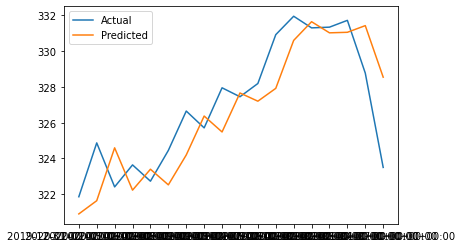

In [33]:
#plot the given stocks data and the predicted data from the validation data
plt.plot(val.tail(val_y.shape[0]).index,val_y,label = 'Actual')
plt.plot(val.tail(val_y.shape[0]).index,y_hat_val,label = 'Predicted')
plt.legend(loc='upper left')

In [34]:
#predict using testing data
y_hat_test = reg.predict(testing_x)
#print(y_hat_test-testing_y)


In [35]:
x = np.array([[1,2,3,4],[5,6,7,8]])
Xy= np.hstack((x,x))
print(Xy) ################################adding features

[[1 2 3 4 1 2 3 4]
 [5 6 7 8 5 6 7 8]]


dict_keys(['C', 'dual', 'epsilon', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'random_state', 'tol', 'verbose'])
(498,)
(498, 2)


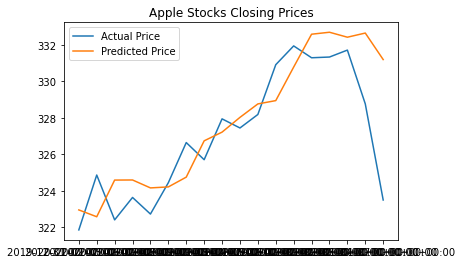

In [36]:
#Grid search for SVR

#initialize the hyperparameters
params = {'C' : [1,5,10],
          'epsilon': [0.001,0.005,0.0075],
         'fit_intercept' : [3,8,5],
         'max_iter' : [0.01,10,0.5],
         'random_state': [0,5,10],}

#find hyperparameters to optimize
print(LinearSVR().get_params().keys())

#create a linear regressor 
SVRModel = LinearSVR(random_state=0, tol=1e-5)
#perform grid search on Linear SVR
grids = GridSearchCV(SVRModel,params,cv=5)
print(train_y.shape)
print(train_x.shape)
#fit the grid with training data
grids = grids.fit(train_x, train_y)
#predict the grid with validation data
y_clf_val = grids.predict(val_x)
#plot the stocks data and the predicted data from the validation data
plt.title('Apple Stocks Closing Prices')
plt.plot(val.tail(val_y.shape[0]).index,val_y,label = 'Actual Price')
plt.plot(val.tail(val_y.shape[0]).index,y_clf_val,label = 'Predicted Price')
plt.legend(loc='upper left')

In [37]:
def mulitvariate_preprocessing(num_features,time_steps, df, num_predictions, sampling_method, sampling_window = 1):
    '''
    Ex:
    num_predictions = 2
    input : t1,t2,t3,t4,t5
    target : t3,t4,t5,t6,t7
    predictions = t6,t7
    sampling method: either you push the sliding window along the data or you jump ie select sample [0,timestep],[timestep,2*timstep] etc..
    
    '''  
    
    sampling_index = 0
    end_sampling_index = time_steps

    #set final subsampling shape Temp array to append actual data in the right shape
    temp = np.arange(time_steps) 
    for i in range(num_features-1):
        temp = np.vstack((temp,np.arange(time_steps))) #end of for loop you get 4 depth,20  input length shape
    temp = np.vstack(([temp],[temp])) #shape (2,4,20) or (samples, channels/features, time length)


    train_Set = df.iloc[sampling_index:end_sampling_index, [0]].to_numpy().flatten() #first time_steps samples
    #print(train_Set)
        
    if sampling_method == 'sliding_window':
        
        
        target_start = num_predictions  #retrieve t+1
        target_end = target_start + time_steps
        y_train = df.iloc[target_start:target_end, [0]].to_numpy().flatten() #first target samples

        
        for i in range((df.shape[0]-num_predictions-time_steps)+sampling_window): #loop of data to generate samples
  
            for i in range(1,num_features): #loop to iterate over features for x
               
                train_Set = np.vstack((train_Set,
                                   df.iloc[sampling_index:end_sampling_index, [i]].to_numpy().flatten()))
                
            #print('x',train_Set[0:1,])
            
            sampling_index += sampling_window
            end_sampling_index += sampling_window
            
            target_start += sampling_window
            target_end += sampling_window
            
                
            temp = np.vstack((temp,[train_Set])) #shape n, feature,time length
            train_Set = df.iloc[sampling_index:end_sampling_index, [0]].to_numpy().flatten() #reset to get shape 20, -> array of sub-sampled prices
            
            if target_end > df.shape[0]:
                break #error checking condition
            #y-value
            y_train = np.vstack((y_train,
                                        df.iloc[target_start:target_end, [0]].to_numpy().flatten()))

        y_train = y_train.reshape(-1,1,time_steps).astype('float32') #reshape to sample, 1 ,timesteps
            
            
    else:
        #jumping by timesteps
        
        for i in range(int(df.shape[0])//time_steps):
            for i in range(1,num_features):

                train_Set = np.vstack((train_Set,
                                       df.iloc[sampling_index:end_sampling_index, [i]].to_numpy().flatten()))
                
            #print('x',train_Set[0:1,])
            sampling_index += time_steps
            end_sampling_index += time_steps
            
            temp = np.vstack((temp,[train_Set])) #shape n, feature,time length
            train_Set = df.iloc[sampling_index:end_sampling_index, [0]].to_numpy().flatten() #reset to get shape 20, -> array of sub-sampled prices
    

        y_train = df['close'].tail(df.shape[0]-num_predictions) # last n - num_prediction values
        y_train = y_train.to_numpy().flatten().reshape(-1,1,time_steps).astype('float32')    
        
    
    print('Finish resampling')
    
    temp = temp[2:,:,:].astype('float32')
    
    return temp, y_train